In [1]:
# imports
import datasets
import evaluate
import numpy as np
import pandas as pd
import peft
import pickle
import transformers

from datasets import(
    load_dataset, 
)


from peft import(
    LoraConfig,
    get_peft_model,
)

from transformers import(
AutoModelForCausalLM,
AutoTokenizer,
TrainingArguments
)
from trl import SFTTrainer, SFTConfig

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-31 18:37:37.938287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743446257.952604 1791354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743446257.957034 1791354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743446257.969697 1791354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

In [2]:
# model
def model_from_pkl(model):
    with open("pkl_files/" + model + ".pkl", "rb") as f:
        pkl_model=pickle.load(f)
    model_name=pkl_model["model_name"]
    tokenizer=pkl_model["tokenizer"]
    tokenizer.pad_token=tokenizer.eos_token
    return model_name, tokenizer
llama, llama_tokenizer=model_from_pkl("Llama-3.2-1B")

In [3]:
# LORA config
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)
lla_lora_model=get_peft_model(llama, config)

In [4]:
# data
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
def tokenize_l_function(examples):
        return llama_tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_train=ds_gst1_train.map(tokenize_l_function, batched=True)
tokenized_test=ds_gst1_test.map(tokenize_l_function, batched=True)

In [5]:
# define trainer parameters (besides compute_metrics)
training_args=TrainingArguments(output_dir="test_trainer", 
                                #eval_strategy="epoch", 
                                per_device_train_batch_size=8,
                                num_train_epochs=3, # total number of training epochs to perform)
                                learning_rate=2e-4,
                                weight_decay=0.1,
                                logging_strategy="steps",
                                #logging_steps=2,
                                gradient_checkpointing=True)
# eval_strategy=epoch ensures that the evaluation metric will be reported at the end of each epoch
# this helps us monitor evaluation metrics during fine-tuning

In [6]:
# compute_metrics
metric=evaluate.load("accuracy")
print(metric)

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
    

In [28]:
comp_metrics_output=[]
def compute_metrics(eval_pred):
    logits=eval_pred.predictions
    refs=eval_pred.label_ids
    log_32=logits.astype(np.int32)
    log_32=np.concatenate(log_32).tolist()
    ref_32=refs.astype(np.int32)
    ref_32=np.concatenate(ref_32).tolist()
    predictions = np.argmax(log_32, axis=-1)
    met=metric.compute(predictions=predictions, references=ref_32)
    comp_metrics_output.append(met)
    return met

In [29]:
l_trainer = SFTTrainer(
    model=lla_lora_model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    peft_config=config,
    args=SFTConfig(output_dir="test_trainer", 
                   eval_strategy="epoch",
                   logging_strategy="steps",
                   logging_steps=2, 
                  ),
    compute_metrics=compute_metrics
)

In [30]:
l_trainer.train() 

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.641500,2.568233,0.000313
2,0.643700,2.565880,0.000195
3,0.648100,2.565564,0.000215


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6456151679158211, metrics={'train_runtime': 1113.1273, 'train_samples_per_second': 1.348, 'train_steps_per_second': 0.043, 'total_flos': 8976366305280000.0, 'train_loss': 0.6456151679158211})

In [31]:
comp_metrics_output[0]

{'accuracy': 0.0003125}

In [64]:
def get_training_output(trainer, keys: list, eval_type, num_steps):
    trainer_info=[]
    logs=l_trainer.state.log_history
    for i in logs:
        if (i['epoch']==1) or (i['epoch']==2) or (i['epoch']==3):
            if 'loss' in i:
                trainer_info.append({'loss': i['loss']})
    df=pd.DataFrame(trainer_info)
    df
    # df=df.filter(items=['loss', 'eval_loss', 'eval_accuracy'])
    # df['eval_loss']=df['eval_loss'].shift(-1)
    # df['eval_accuracy']=df['eval_accuracy'].shift(-1)
    # df=df.dropna()
    # df

,loss
0,0.6415
1,0.6437
2,0.6481


In [136]:
def get_training_output(trainer, keys: list, num_steps=None):
    trainer_info=[]
    temp_dict={}
    logs=trainer.state.log_history
    for i in logs:
        if (l_trainer.args.eval_strategy=='epoch'):
            if(i['epoch'].is_integer()==True):
                for j in keys:
                    if j in i:
                        temp_dict[j]=i[j]
                if j in temp_dict:
                    trainer_info.append(temp_dict)
                    temp_dict={}
        #elif(l_trainer.args.eval_strategy=='steps'):
            
    return trainer_info
            

<Axes: title={'center': 'Llama3 Fine-Tuning Accuracy Evaluation'}, xlabel='Epochs', ylabel='Accuracy'>

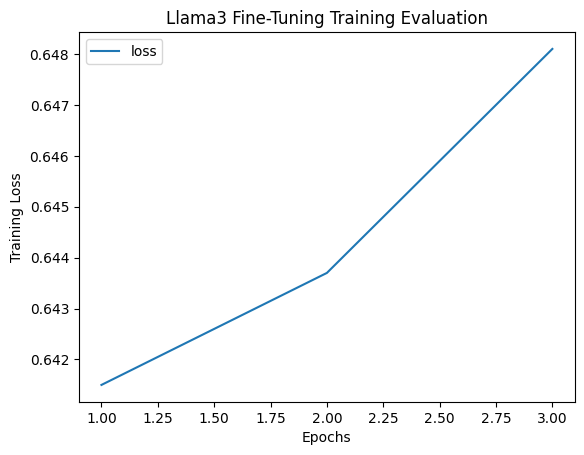

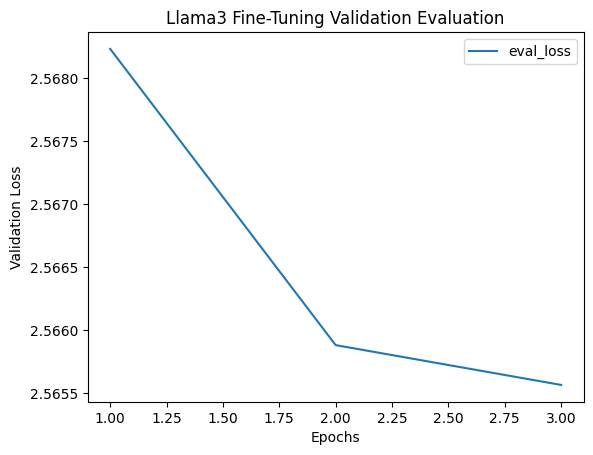

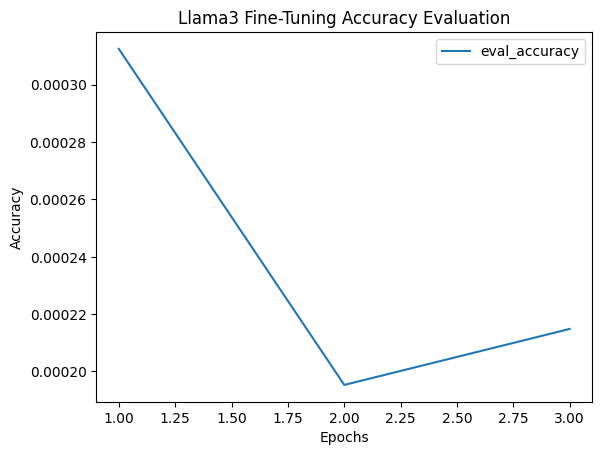

In [137]:
trainer_info=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
df=pd.DataFrame(trainer_info)
df.index=df.index+1
df.plot(y=0, xlabel="Epochs", ylabel="Training Loss", title="Llama3 Fine-Tuning Training Evaluation")
df.plot(y=1, xlabel="Epochs", ylabel="Validation Loss", title="Llama3 Fine-Tuning Validation Evaluation")
df.plot(y=2, xlabel="Epochs", ylabel="Accuracy", title="Llama3 Fine-Tuning Accuracy Evaluation")
#trainer_info

In [74]:
val=training_args.num_train_epochs
val2=l_trainer.args.eval_strategy
val2=='epoch'

True

In [43]:
logs[:5]

[{'loss': 0.6407,
  'grad_norm': 0.022022800520062447,
  'learning_rate': 1.916666666666667e-05,
  'num_tokens': 65536.0,
  'mean_token_accuracy': 0.20863880962133408,
  'epoch': 0.125,
  'step': 2},
 {'loss': 0.6493,
  'grad_norm': 0.020250247791409492,
  'learning_rate': 1.8333333333333333e-05,
  'num_tokens': 131072.0,
  'mean_token_accuracy': 0.20590481162071228,
  'epoch': 0.25,
  'step': 4},
 {'loss': 0.6455,
  'grad_norm': 0.022340381518006325,
  'learning_rate': 1.7500000000000002e-05,
  'num_tokens': 196608.0,
  'mean_token_accuracy': 0.2085929811000824,
  'epoch': 0.375,
  'step': 6},
 {'loss': 0.6397,
  'grad_norm': 0.021601686254143715,
  'learning_rate': 1.6666666666666667e-05,
  'num_tokens': 262144.0,
  'mean_token_accuracy': 0.21931512653827667,
  'epoch': 0.5,
  'step': 8},
 {'loss': 0.652,
  'grad_norm': 0.023153146728873253,
  'learning_rate': 1.5833333333333333e-05,
  'num_tokens': 327680.0,
  'mean_token_accuracy': 0.2018725499510765,
  'epoch': 0.625,
  'step': 10

     0       1         2         3
0  1.0  0.6454  2.586096  0.000469
1  2.0  0.6473  2.582443  0.000469
2  3.0  0.6517  2.580906  0.000391


<Axes: title={'center': 'Llama3 Fine-Tuning Accuracy Evaluation'}, xlabel='Epochs', ylabel='Accuracy'>

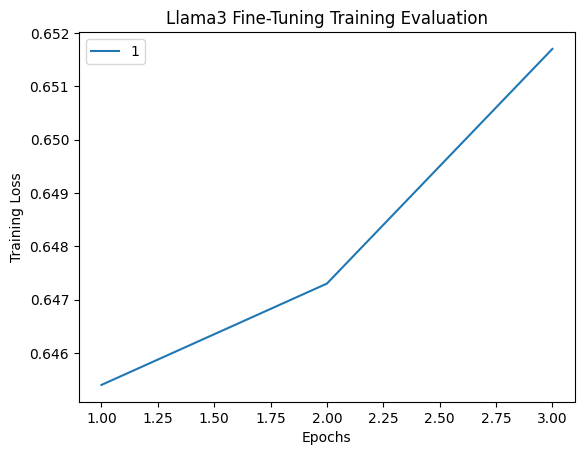

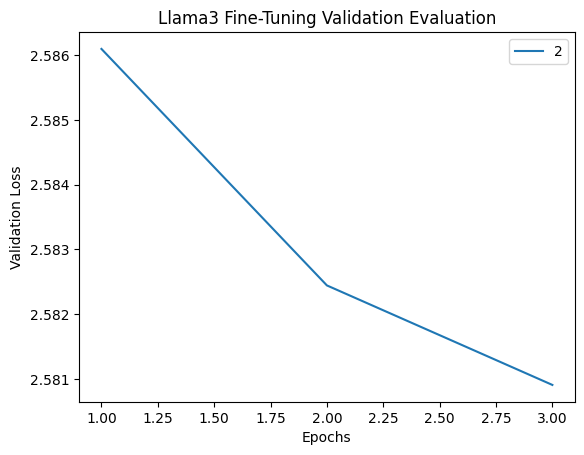

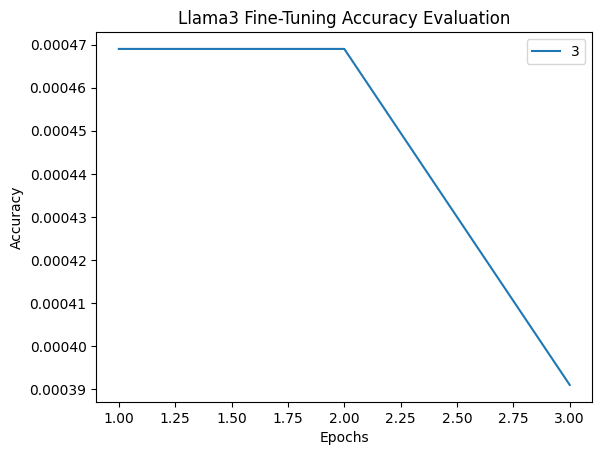

In [26]:
df_data=[[float(val) for val in line.split("\t")] for line in"""1 	0.645400 	2.586096 	0.000469
2 	0.647300 	2.582443 	0.000469
3 	0.651700 	2.580906 	0.000391""".split("\n")[0:]]
df=pd.DataFrame(df_data)
print(df)
#print(df[0]) #first column of data, the number of epochs
#print(df[1]) #second column of data, training loss at each epoch
#print(df[2]) #third column, validation loss
#print(df[3]) #fourth column, accuracy
df.plot(x=0, y=1, xlabel="Epochs", ylabel="Training Loss", title="Llama3 Fine-Tuning Training Evaluation")
df.plot(x=0, y=2, xlabel="Epochs", ylabel="Validation Loss", title="Llama3 Fine-Tuning Validation Evaluation")
df.plot(x=0, y=3, xlabel="Epochs", ylabel="Accuracy", title="Llama3 Fine-Tuning Accuracy Evaluation")

In [24]:
l_trainer2 = SFTTrainer(
    model=lla_lora_model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    peft_config=config,
    args=SFTConfig(output_dir="test_trainer", 
                   eval_strategy="steps",
                   logging_strategy="steps",
                   logging_steps=6, 
                  ),
    compute_metrics=compute_metrics
)

In [25]:
l_trainer2.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.647200,2.578385,0.000332
12,0.649500,2.576008,0.000391
18,0.644800,2.574740,0.000332
24,0.648300,2.573750,0.000410
30,0.648200,2.572867,0.000293
36,0.646600,2.572278,0.000254
42,0.645100,2.571825,0.000234
48,0.648200,2.571646,0.000234


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6472295870383581, metrics={'train_runtime': 2921.6359, 'train_samples_per_second': 0.513, 'train_steps_per_second': 0.016, 'total_flos': 8976366305280000.0, 'train_loss': 0.6472295870383581})

      0       1         2         3
0   6.0  0.6472  2.578385  0.000332
1  12.0  0.6495  2.576008  0.000391
2  18.0  0.6448  2.574740  0.000332
3  24.0  0.6483  2.573750  0.000410
4  30.0  0.6482  2.572867  0.000293
5  36.0  0.6466  2.572278  0.000254
6  42.0  0.6451  2.571825  0.000234
7  48.0  0.6482  2.571646  0.000234


<Axes: title={'center': 'Llama3 Fine-Tuning Accuracy Evaluation'}, xlabel='Steps', ylabel='Accuracy'>

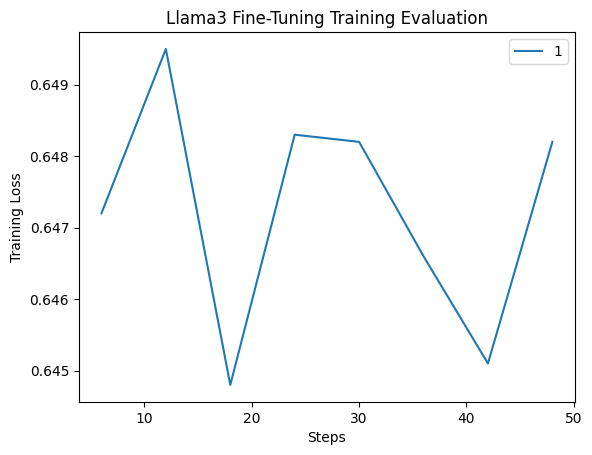

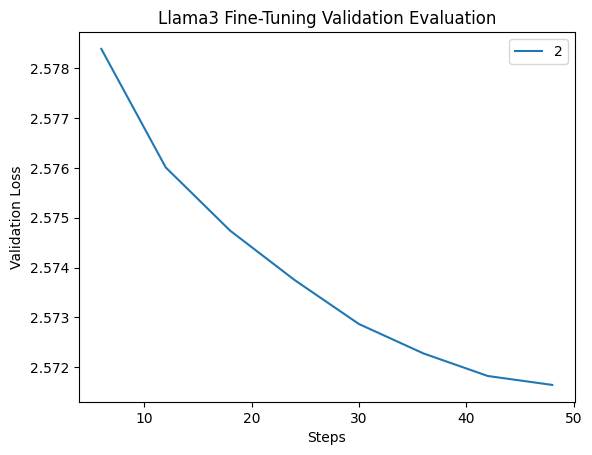

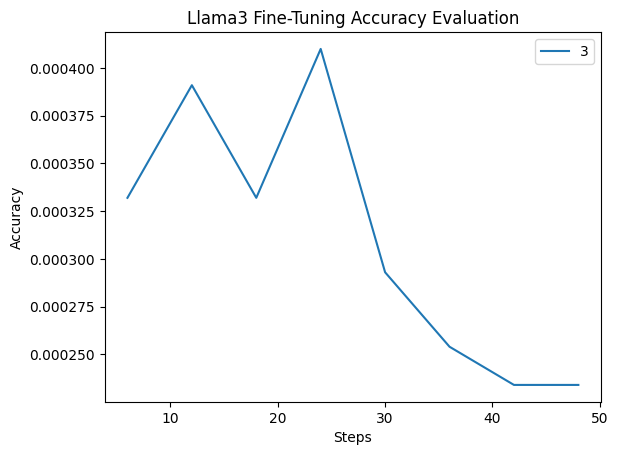

In [27]:
df_data=[[float(val) for val in line.split("\t")] for line in"""6 	0.647200 	2.578385 	0.000332
12 	0.649500 	2.576008 	0.000391
18 	0.644800 	2.574740 	0.000332
24 	0.648300 	2.573750 	0.000410
30 	0.648200 	2.572867 	0.000293
36 	0.646600 	2.572278 	0.000254
42 	0.645100 	2.571825 	0.000234
48 	0.648200 	2.571646 	0.000234""".split("\n")[0:]]
df=pd.DataFrame(df_data)
print(df)
#print(df[0]) #first column of data, the number of steps
#print(df[1]) #second column of data, training loss at each step
#print(df[2]) #third column, validation loss
#print(df[3]) #fourth column, accuracy
df.plot(x=0, y=1, xlabel="Steps", ylabel="Training Loss", title="Llama3 Fine-Tuning Training Evaluation")
df.plot(x=0, y=2, xlabel="Steps", ylabel="Validation Loss", title="Llama3 Fine-Tuning Validation Evaluation")
df.plot(x=0, y=3, xlabel="Steps", ylabel="Accuracy", title="Llama3 Fine-Tuning Accuracy Evaluation")